In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
37836,NaN,NaN,International,2020-03-08,NaN,NaN,0.000,NaN,NaN,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37837,NaN,NaN,International,2020-03-09,NaN,NaN,0.000,NaN,NaN,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37838,NaN,NaN,International,2020-03-10,696.0,-9.0,-1.286,7.0,1.0,0.143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


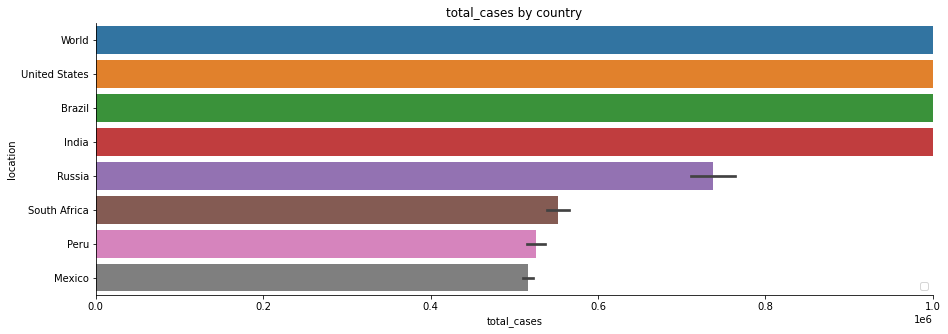

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


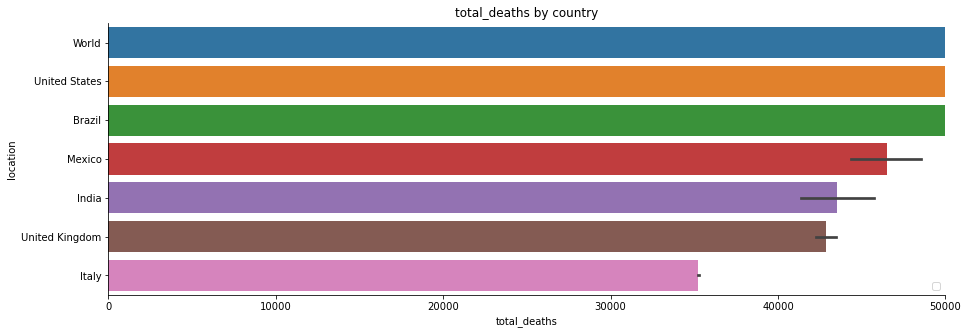

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


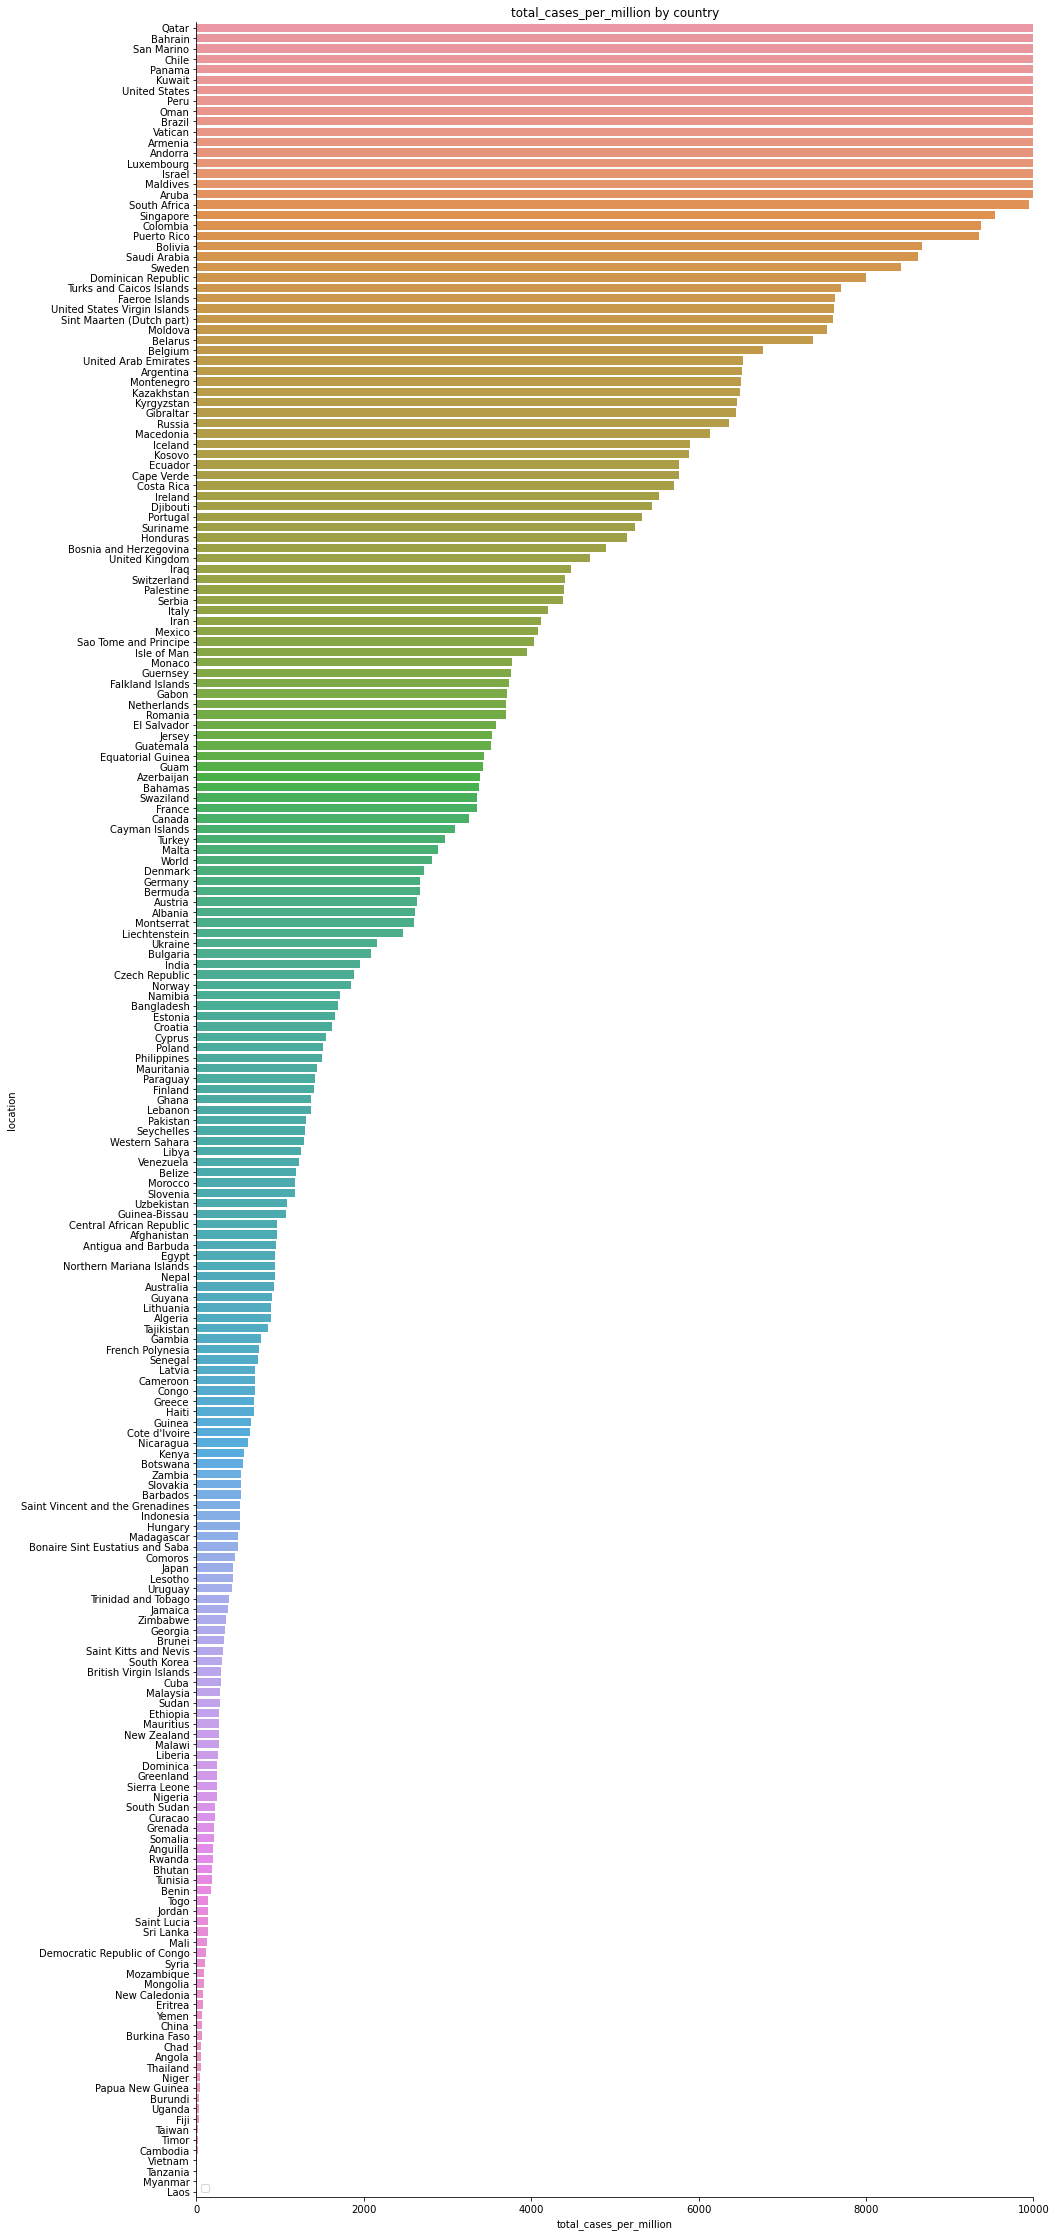

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


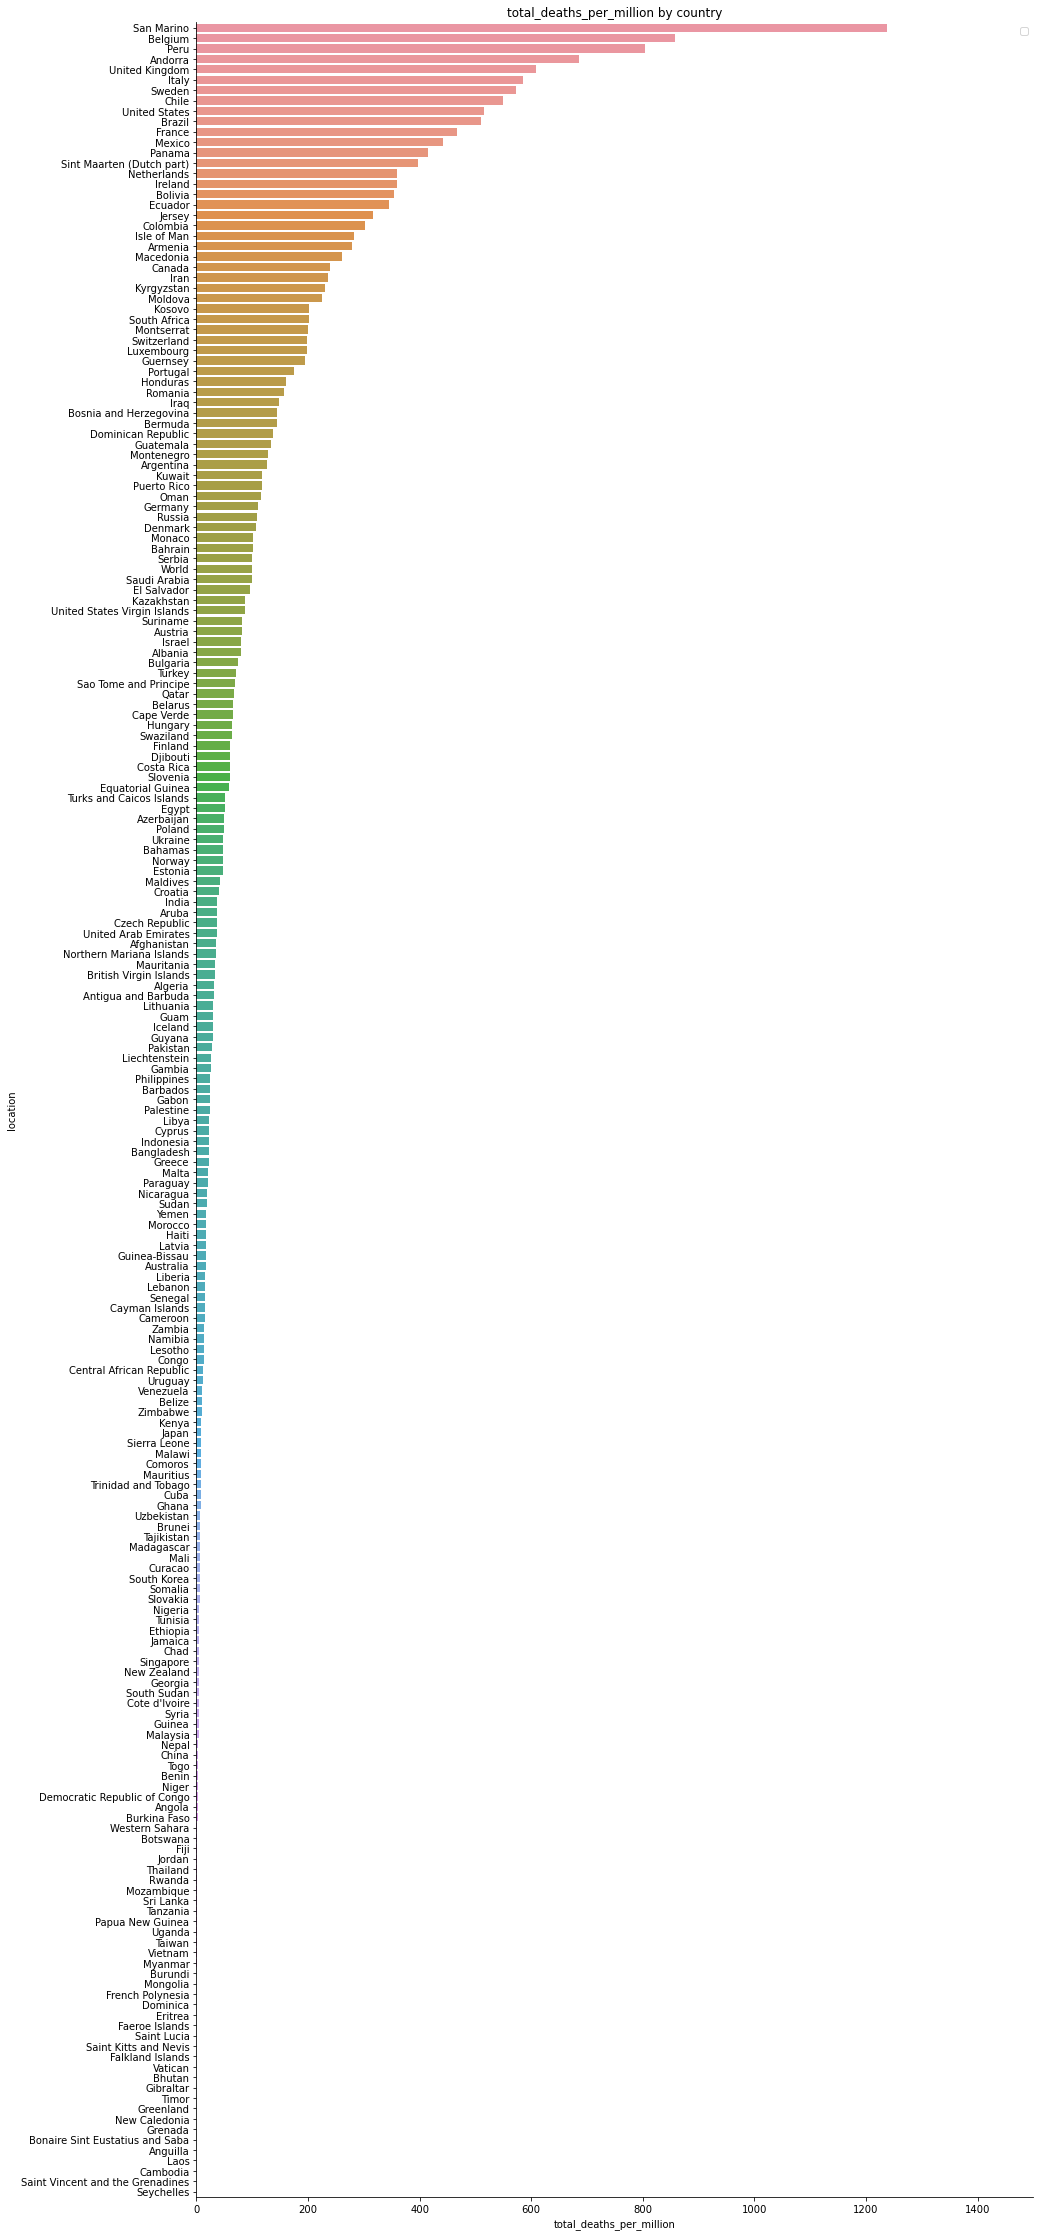

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

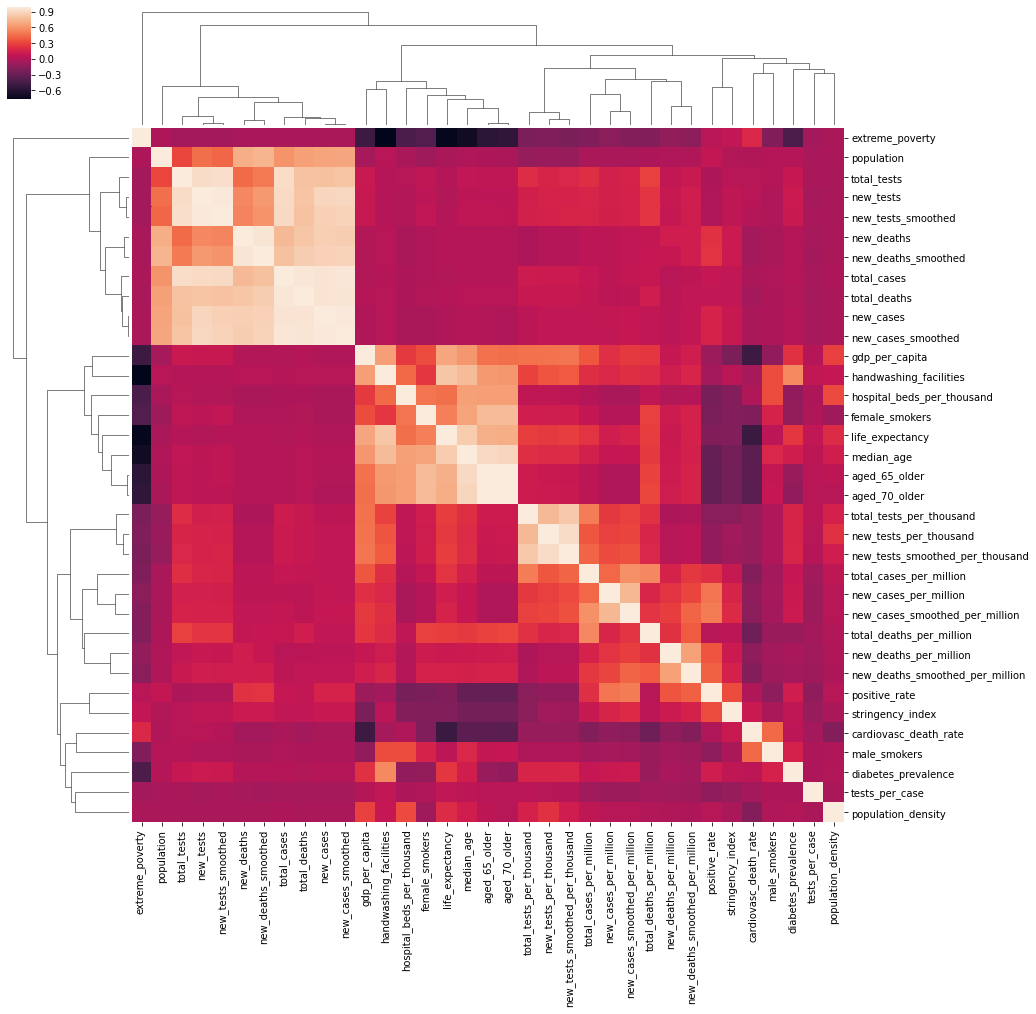

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9995808288885174 (+/- 0.00020303313938753266)
Coef :  [1.04244933e+00 8.07066558e-05 8.78128776e-05]
3 Last_days :  [[21474280 21706312 21896155]]
Today :  21896155
Prediction + :  560567
Tomorow :  22456722
                                     
--------- Total Death -----------------
                                     
R^2: 0.999568396975179 (+/- 7.853905004901836e-05)
Coef :  [-0.08220141  0.52762276  0.56421439]
3 Last_days :  [[766087 770306 774539]]
Today :  774539
Prediction + :  8107
Tomorow :  782646
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9785211718898452 (+/- 0.021348320445179664)
Coef :  [-0.66893699  0.73465039  0.93500227]
3 Last_days :  [[215521 218536 219029]]
Today :  219029
Prediction + :  2464
Tomorow :  221493
                                     
--------- Total Death -----------------
                                     
R^2: 0.41473431929976184 (+/- 0.8131671899638201)
Coef :  [-0.75538745  0.78835145  0.96615658]
3 Last_days :  [[30409 30410 30429]]
Today :  30429
Prediction + :  24
Tomorow :  30453
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.799534333073667 (+/- 0.14188591244163873)
Coef :  [-0.32161106 -0.0252941   1.34117941]
3 Last_days :  [[89279 89375 89441]]
Today :  89441
Prediction + :  70
Tomorow :  89511
                                     
--------- Total Death -----------------
                                     
R^2: -1498.7842453317583 (+/- 2120.7313865027822)
Coef :  [-0.07659222  0.01240777  1.05622893]
3 Last_days :  [[4703 4703 4703]]
Today :  4703
Prediction + :  6
Tomorow :  4709
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.7710395022285947 (+/- 0.32222752618387196)
Coef :  [-0.83735634  0.90486908  0.93168212]
3 Last_days :  [[253438 253915 254235]]
Today :  254235
Prediction + :  543
Tomorow :  254778
                                     
--------- Total Death -----------------
                                     
R^2: 0.9410859846170373 (+/- 0.05361051411041935)
Coef :  [-0.83513942  0.90277835  0.93156467]
3 Last_days :  [[35392 35396 35400]]
Today :  35400
Prediction + :  26
Tomorow :  35426
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.5984604648237322 (+/- 0.5557045164577677)
Coef :  [-0.74984993  0.67433646  1.07612218]
3 Last_days :  [[342813 342813 359082]]
Today :  359082
Prediction + :  1690
Tomorow :  360772
                                     
--------- Total Death -----------------
                                     
R^2: 0.274584355211048 (+/- 0.8668173843766371)
Coef :  [-0.71744894  0.60845961  1.10799361]
3 Last_days :  [[28617 28617 28646]]
Today :  28646
Prediction + :  12
Tomorow :  28658
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9963143574232393 (+/- 0.004865649136216795)
Coef :  [0.09680361 0.45443793 0.46871723]
3 Last_days :  [[5361165 5403269 5438325]]
Today :  5438325
Prediction + :  96080
Tomorow :  5534405
                                     
--------- Total Death -----------------
                                     
R^2: 0.48855641722833204 (+/- 0.721760990085491)
Coef :  [-0.63227852  0.76928444  0.86506909]
3 Last_days :  [[169481 170052 170497]]
Today :  170497
Prediction + :  904
Tomorow :  171401
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9962222989592394 (+/- 0.003953436925601731)
Coef :  [-0.78154644  0.87696655  0.90465963]
3 Last_days :  [[317444 318484 319197]]
Today :  319197
Prediction + :  1202
Tomorow :  320399
                                     
--------- Total Death -----------------
                                     
R^2: 0.3336123668422035 (+/- 0.6906341299108341)
Coef :  [-0.45430546  0.32000133  1.13351904]
3 Last_days :  [[41361 41366 41369]]
Today :  41369
Prediction + :  61
Tomorow :  41430
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.992475974682525 (+/- 0.008415213833681445)
Coef :  [-0.81409741  0.86686503  0.9466809 ]
3 Last_days :  [[223453 224014 224014]]
Today :  224014
Prediction + :  629
Tomorow :  224643
                                     
--------- Total Death -----------------
                                     
R^2: 0.4490753625769421 (+/- 0.7682390433172742)
Coef :  [-0.79733789  0.84264323  0.9540963 ]
3 Last_days :  [[9231 9232 9232]]
Today :  9232
Prediction + :  8
Tomorow :  9240
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.4181680775124958 (+/- 0.8223055916459143)
Coef :  [0.16775347 0.42285661 0.42235858]
3 Last_days :  [[341070 343203 345450]]
Today :  345450
Prediction + :  3980
Tomorow :  349430
                                     
--------- Total Death -----------------
                                     
R^2: 0.8829521421486891 (+/- 0.16520339904377623)
Coef :  [-0.04073672  0.53036431  0.52444429]
3 Last_days :  [[19492 19639 19804]]
Today :  19804
Prediction + :  243
Tomorow :  20047
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9986225238587166 (+/- 0.0016838769768448292)
Coef :  [-0.7600396   0.85873533  0.8984825 ]
3 Last_days :  [[248117 249309 250542]]
Today :  250542
Prediction + :  1048
Tomorow :  251590
                                     
--------- Total Death -----------------
                                     
R^2: 0.9992701126627462 (+/- 0.0006923112502754881)
Coef :  [-0.82348779  0.90077581  0.91972254]
3 Last_days :  [[5955 5974 5996]]
Today :  5996
Prediction + :  17
Tomorow :  6013
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.46850051975505863 (+/- 0.7483327047900137)
Coef :  [-0.17763526  0.47784174  0.71784342]
3 Last_days :  [[3317096 3340197 3359570]]
Today :  3359570
Prediction + :  63732
Tomorow :  3423302
                                     
--------- Total Death -----------------
                                     
R^2: 0.51001131779299 (+/- 0.6879981401483477)
Coef :  [-0.21333732  0.55521536  0.67090753]
3 Last_days :  [[107232 107852 108536]]
Today :  108536
Prediction + :  1491
Tomorow :  110027
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(21896155, 774539, 22456722, 782646),
 (219029, 30429, 221493, 30453),
 (254235, 35400, 254778, 35426),
 (359082, 28646, 360772, 28658),
 (5438325, 170497, 5534405, 171401),
 (89441, 4703, 89511, 4709),
 (319197, 41369, 320399, 41430),
 (224014, 9232, 224643, 9240),
 (345450, 19804, 349430, 20047),
 (250542, 5996, 251590, 6013),
 (3359570, 108536, 3423302, 110027)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-08-18,France,221493.0,0.0,30453.0,0.0,0.0,0.0
0,2020-08-18,China,89511.0,0.0,4709.0,0.0,0.0,0.0
0,2020-08-18,Italy,254778.0,0.0,35426.0,0.0,0.0,0.0
0,2020-08-18,Spain,360772.0,0.0,28658.0,0.0,0.0,0.0
0,2020-08-18,United States,5534405.0,0.0,171401.0,0.0,0.0,0.0
0,2020-08-18,World,22456722.0,0.0,782646.0,0.0,0.0,0.0
0,2020-08-18,United Kingdom,320399.0,0.0,41430.0,0.0,0.0,0.0
0,2020-08-18,Germany,224643.0,0.0,9240.0,0.0,0.0,0.0
0,2020-08-18,Iran,349430.0,0.0,20047.0,0.0,0.0,0.0
0,2020-08-18,Turkey,251590.0,0.0,6013.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")